In [1]:
# fill namespace with nupy and matplotlib + static notebook plots
%pylab inline
# fill namespace with nupy and matplotlib + and interactive plots
#%pylab notebook 
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.rtlsdr_helper as sdr
import imp # for module reloading
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
#Image('fname.png',width='80%')

# Record a Short Message to be PCM Encoded
Using `pyaudio_helper` record a short message that will ultimately be PCM encoded and stored in C header file along with a preamble/frame sync pattern.

In [3]:
import sk_dsp_comm.pyaudio_helper as pah

* Find the mircophone inputs available on this PC for making the recording:

In [4]:
pah.available_devices()

Index 0 device name = Built-in Microphone, inputs = 2, outputs = 0
Index 1 device name = Built-in Output, inputs = 0, outputs = 2


* We will use device index 0, which here is an on-board mic

In [12]:
# define an audio record callback
# Here we configure the callback to capture a one channel input
def callback(in_data, frame_count, time_info, status):
    
    DSP_IO.DSP_callback_tic()
    
    # convert byte data to ndarray
    in_data_nda = np.fromstring(in_data, dtype=np.int16)
    #***********************************************
    # DSP operations here
    # Here we apply a linear filter to the input
    x = in_data_nda.astype(float32)
    y = x 
    #***********************************************
    # Save data for later analysis
    # accumulate a new frame of samples
    DSP_IO.DSP_capture_add_samples(y)
    #***********************************************
    # Convert from float back to int16
    y = 0*y.astype(int16)
    DSP_IO.DSP_callback_toc()
    # Convert ndarray back to bytes
    #return (in_data_nda.tobytes(), pyaudio.paContinue)
    return y.tobytes(), pah.pyaudio.paContinue

In [13]:
DSP_IO = pah.DSP_io_stream(callback,0,1,fs=8000)

In [14]:
DSP_IO.stream(5)

Audio input/output streaming session complete!


In [24]:
speech = DSP_IO.data_capture[4000:26000]
speech  /= max(abs(speech))

In [6]:
#ss.to_wav('speech.wav',8000,speech)
Audio('speech.wav')

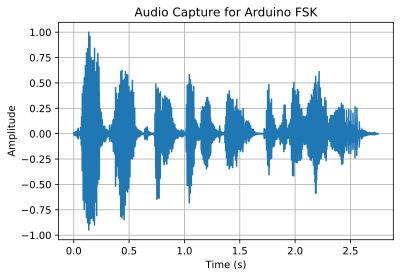

In [7]:
fs, speech = ss.from_wav("speech.wav")
plot(arange(len(speech))/8000,speech)
title(r'Audio Capture for Arduino FSK')
ylabel(r'Amplitude')
xlabel(r'Time (s)')
grid();

In [31]:
x_bits = dc.PCM_encode(speech,8)

In [5]:
x_PN63 = dc.m_seq(6)
x_PN63.shape

(63,)

In [7]:
def Bits_header(fname_out,h):
    """
    Write a 0/1 data bits Header Files 
    
    Mark Wickert July 2017
    """
    M = len(h)
    N = 25 # Coefficients per line
    f = open(fname_out,'wt')
    f.write('//define a Data Bits Array\n\n')
    f.write('#include <stdint.h>\n\n')
    f.write('#ifndef M_BIT\n')
    f.write('#define M_BIT %d\n' % M)
    f.write('#endif\n')
    f.write('/************************************************************************/\n');
    f.write('/*                            The Data Bits                             */\n');
    f.write('int8_t x_BITS[M_BIT] = {')
    kk = 0;
    for k in range(M):
        #k_mod = k % M
        if (kk < N-1) and (k < M-1):
            f.write('%1d,' % h[k])
            kk += 1
        elif (kk == N-1) & (k < M-1):
            f.write('%1d,\n' % h[k])
            if k < M:
                f.write('                        ')
                kk = 0
        else:
            f.write('%1d' % h[k])    
    f.write('};\n')
    f.write('/************************************************************************/\n')
    f.close()

In [8]:
#x_tx_bits = hstack((x_PN63,x_bits))
x_tx_bits = x_PN63
Bits_header('x_tx_bits.h',x_tx_bits)

** Arduino Maximum array lengths
```C
char a[ 32767 ];
short b[ 16383 ];
int c[ 16383 ];
long d[ 8191 ];
long long e[ 4095 ];
float f[ 8191 ];
double g[ 8191 ]; //double is the same size as float
```

The bit stream sent over the air is:
```C
//define a Data Bits Array

#include <stdint.h>

#ifndef M_BIT
#define M_BIT 63
#endif
/************************************************************************/
/*                            The Data Bits                             */
int16_t x_BITS[M_BIT] = {1,1,1,1,1,1,0,1,0,1,0,1,1,0,0,1,1,0,1,1,1,0,1,1,0,
                         1,0,0,1,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,0,1,0,1,0,0,
                         0,1,1,0,0,0,0,1,0,0,0,0,0};
/************************************************************************/
```

In [44]:
# From the docstring
#x = sdr.capture(Tc, fo=88700000.0, fs=2400000.0, gain=40, device_index=0)
x = sdr.capture(Tc=8,fo=106.9e6,fs=2.4e6,gain=40,device_index=0)

In [45]:
sdr.complex2wav('FSK_1kbps_biphase.wav',2400000,x)

Saved as binary wav file with (I,Q)<=>(L,R)


In [9]:
fs, x = sdr.wav2complex('FSK_1kbps_biphase.wav')

(-200, 200)

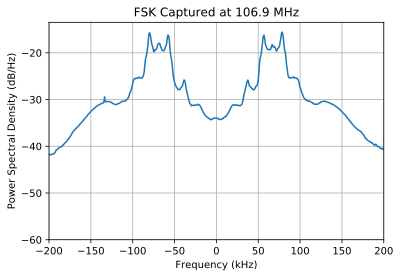

In [10]:
# Plot the power spectral density of the raw capture
psd(x,2**12,2400);
title(r'FSK Captured at 106.9 MHz')
xlabel(r'Frequency (kHz)');
xlim([-200,200])

In [11]:
def FSK_demod(x,fs=2.4e6,B1=200e3,N1=6,B2=10e3,N2=5):
    """
    FSK Demod
    Defaults ok for Rb = 1 kbps bi-phase encoding
    """
    b = signal.firwin(64,2*B1/float(fs))
    # Filter and decimate (should be polyphase)
    y = signal.lfilter(b,1,x)
    z = ss.downsample(y,N1)
    # Apply complex baseband discriminator
    z_bb = sdr.discrim(z)
    z_bb -= mean(z_bb)
    # Design 2nd decimation lowpass filter
    bb = signal.firwin(64,2*B2/(float(fs)/N1))
    # Filter and decimate
    zz_bb = signal.lfilter(bb,1,z_bb)
    # Decimate by N2
    z_out = ss.downsample(zz_bb,N2)
    print('Done!')
    return z_bb, z_out

In [12]:
# Demodulate the FSK signal
z_bb, z_demod = FSK_demod(x,B1=200e3,N1=6,B2=10e3,N2=5)

Done!


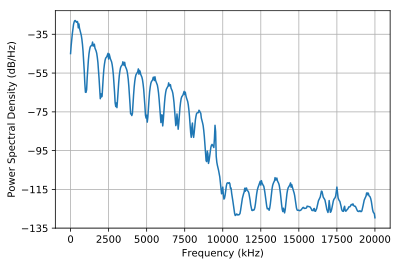

In [59]:
psd(z_demod,2**10,2400000/60);
xlabel(r'Frequency (kHz)')

The half bit period is $T_b/2 = 500\mu\text{s}$, but with biphase encoding the bit rate is $R_b = 1/T_b = 1$ kbps. The sampling rate following the final decimation stage is $2400000/(30) = 80$ ksps, so we have nominally $80000/1000 = 80$ samples per bit.

In [52]:
2400000//30//1000

80

In [37]:
# Create a matched filter to recover the bi-phase encoded FSK
Nb2 = 40
zf = signal.lfilter(hstack((ones(Nb2)/Nb2,-ones(Nb2)/Nb2)),1,z_demod)

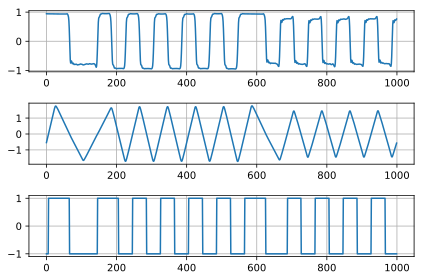

In [38]:
subplot(311)
plot(z_demod[1000:2000])
grid();
subplot(312)
plot(zf[1000:2000])
grid();
subplot(313)
plot(sign(zf[1000:2000]))
grid();
tight_layout()

The Arduino clock and SDR clock are asynchronous, so over time the sampling instant used to convert the waveform back to 1's and 0's will have to advance of retard. It is the job of a bit synchronizer to manage this.  

In [53]:
rx_symb_d,clk,track = sdr.sccs_bit_sync(sign(zf),80) # 80 = ~number of samples per bit

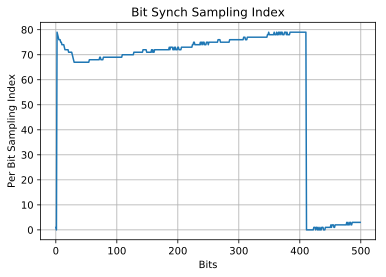

In [58]:
plot(track[:500])
title(r'Bit Synch Sampling Index')
ylabel(r'Per Bit Sampling Index')
xlabel(r'Bits')
grid()

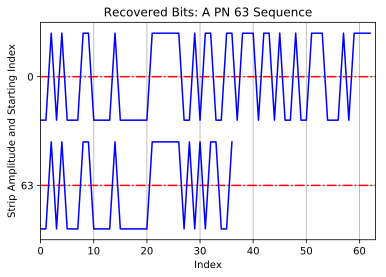

In [56]:
dc.strips(rx_symb_d[:100],63)
title(r'Recovered Bits: A PN 63 Sequence')
grid()